In [1]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mglearn

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 3.4.3 用t-SNE进行流形学习
虽然PCA通常是用于变换数据的首选方法，使你能够用散点图将其可视化，但这一方法的性质(先旋转然后减少方向)限制了其有效性，正如我们在`Wild数据集`的`Labeled Faces`的散点图中所看到的那样。有一类用于可视化的算法叫作流形学习算法(manifold learning algorithm)，它允许进行更复杂的映射，通常也可以给出更好的可视化。其中特别有用的一个就是`t-SNE算法`。

流形学习算法主要用于可视化，因此很少用来生成两个以上的新特征。其中一些算法(包括`t-SNE`)计算训练数据的一种新表示，但不允许变换新数据。这意味着这些算法不能用于测试集：更确切地说，它们只能变换用于训练的数据。

流形学习对探索性数据分析是很有用的，但如果最终目标是监督学习的话，则很少使用。`t-SNE`背后的思想是找到数据的一个二维表示，尽可能地保持数据点之间的距离。`t-SNE`首先给出每个数据点的随机二维表示，然后尝试让在原始特征空间中距离较近的点更加靠近，原始特征空间中相距较远的点更加远离。t-SNE 重点关注距离较近的点，而不是保持距离较远的点之间的距离。换句话说，它试图保存那些表示哪些点比较靠近的信息。

我们将对`scikit-learn`包含的一个手写数字数据集(不要与更大的`MNIST数据集`弄混)应用`t-SNE`流形学习算法。在这个数据集中，每个数据点都是0到9之间手写数字的一张$8*8$灰度图像。`图3-20`给出了每个类别的一个例子：

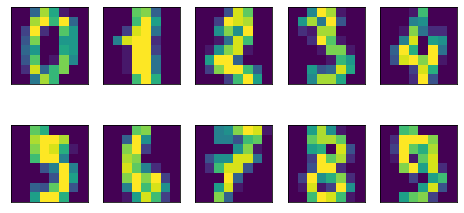

In [2]:
digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(8, 4), subplot_kw={'xticks':(), 'yticks': ()})

for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

plt.show()

我们用PCA将降到二维的数据可视化。我们对前两个主成分作图，并按类别对数据点着色(`图3-21`)：

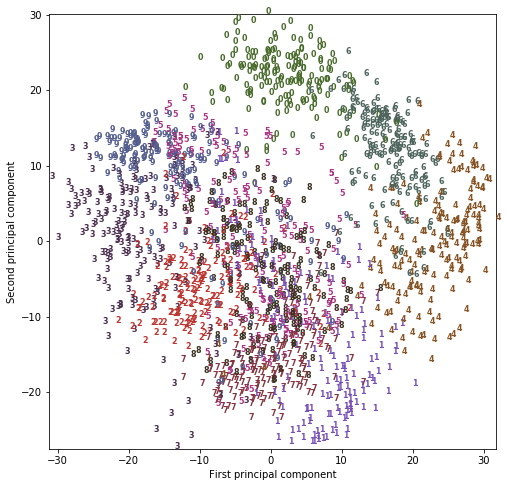

In [3]:
# 构建一个PCA模型
pca = PCA(n_components=2)
pca.fit(digits.data)

# 将digits数据变换到前两个主成分的方向上
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(8, 8))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())

for i in range(len(digits.data)):
    # 将数据实际绘制成文本，而不是散点
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 8})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

这里我们用每个类别对应的数字作为符号来显示每个类别的位置。利用前两个主成分可以将数字0、6和4相对较好地分开，尽管仍有重叠。大部分其他数字都大量重叠在一起。

我们将`t-SNE`应用于同一个数据集，并对结果进行比较。由于`t-SNE`不支持变换新数据，所以没有`transform方法`。我们可以调用`fit_transform方法`来代替，它会构建模型并立刻返回变换后的数据(`图3-22`)：

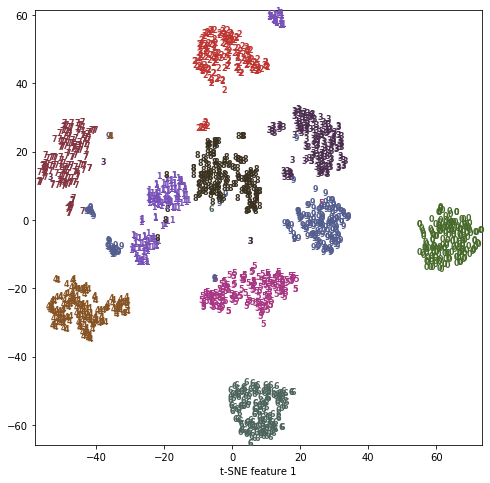

In [4]:
tsne = TSNE(random_state=42)

# 使用fit_transform而不是fit，因为TSNE没有transform方法
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(8, 8))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)

for i in range(len(digits.data)):
    # 将数据实际绘制成文本，而不是散点
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 8})

plt.xlabel("t-SNE feature 0")
plt.xlabel("t-SNE feature 1")
plt.show()

`t-SNE`的结果非常棒。所有类别都被明确分开。数字1和9被分成几块，但大多数类别都形成一个密集的组。要记住，这种方法并不知道类别标签：它完全是无监督的。但它能够找到数据的一种二维表示，仅根据原始空间中数据点之间的靠近程度就能够将各个类别明确分开。

`t-SNE`算法有一些调节参数，虽然默认参数的效果通常就很好。你可以尝试修改`perplexity`和`early_exaggeration`，但作用一般很小。